### Experimenting with Vision Transformers


In this notebook, we are going to take the Vision Transformer that we created in the last notebook and use to classify MNIST Handwritten digits dataset.

So without further adieu lets get started.


#### Imports


In [1]:
## Importing necessary ##

import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid

from visiontransformer import VisionTransformer

from tqdm import tqdm

import matplotlib.pyplot as plt

from torchmetrics.classification import MulticlassAccuracy

## For displaying exact values  and not in exponentiations##
torch.set_printoptions(sci_mode=False)


Now in the next cell we are going to setup the hyperparameters to use.


#### Hyperparameters


In [2]:
## Setting Hyperparameters ##

SEED = 97

# Dataset #
BATCH_SIZE = 32
TRAIN_VAL_TEST_SPLIT = [0.9, 0.05, 0.05]

# Model #
EMBEDDING_DIM = 512
PATCH_SIZE = (7, 7)
NUM_HEADS = 8
NUM_LAYERS = 6
NUM_CLASSES = 10

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Training
LEARNING_RATE = 3e-4
NUM_EPOCHS = 10
DROPOUT_RATE = 0.1

# Saving
CKPT = "checkpoint/bst_vit.pt"
LOAD_MODEL = False


#### Dataset Loading


In [3]:
## Loading MNIST Dataset ##

augmentations = transforms.Compose(
    [
        transforms.Resize(size=(28, 28)),
        transforms.RandomRotation(degrees=30),
        transforms.ToTensor(),
    ]
)

mnist_dataset = MNIST(root="data", train=True, download=True, transform=augmentations)

print(f"Dataset is loaded. It has in total {len(mnist_dataset)} datapoints!!")


Dataset is loaded. It has in total 60000 datapoints!!


Perfect. Now I will be splitting this 60,000 datapoints into train, val and test datasets and utilize a Dataloader for each of them.


In [4]:
## Train val test splits ##

train_dataset, val_dataset, test_dataset = random_split(
    mnist_dataset,
    lengths=[0.8, 0.1, 0.1],
    generator=torch.Generator().manual_seed(SEED),
)

print(f"Train dataset has {len(train_dataset)} datapoints!!")
print(f"Val dataset has {len(val_dataset)} datapoints!!")
print(f"Test dataset has {len(test_dataset)} datapoints!!")


Train dataset has 48000 datapoints!!
Val dataset has 6000 datapoints!!
Test dataset has 6000 datapoints!!


Now we have 3 sepearate datasets. Now its time for modelling them inside dataloaders.


In [5]:
## Dataloader ##

train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Train dataloader has {len(train_dl)} mini-batches!!")
print(f"Validation dataloader has {len(val_dl)} mini-batches!!")
print(f"Test dataloader has {len(test_dl)} mini-batches!!")


Train dataloader has 1500 mini-batches!!
Validation dataloader has 188 mini-batches!!
Test dataloader has 188 mini-batches!!


Perfect. Now finally as a sanity check for the datasets, I am going to visualize a batch of them along with their labels.


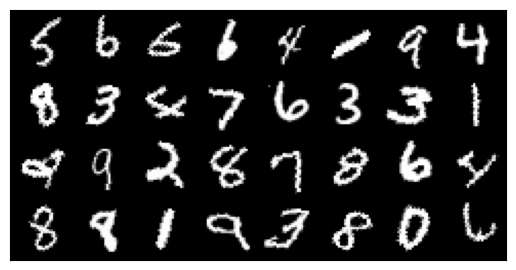

In [6]:
## Visualizing ##

for imgs, labels in train_dl:
    plt.imshow(make_grid(imgs).permute(1, 2, 0))
    plt.tick_params(
        left=False, right=False, labelleft=False, labelbottom=False, bottom=False
    )
    plt.show()
    break


Everything looks awesome with the dataloading. Now, we will move forward and load our model.


#### Setting Model


In [7]:
## Vision Transformer ##

vit = VisionTransformer(
    patch_shape=PATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    dropout_rate=DROPOUT_RATE,
)

if LOAD_MODEL:
    try:
        vit.load_state_dict(torch.load(CKPT))
    except:
        print(f"Check the model checkpoint path!")

vit = vit.to(DEVICE)

print(vit)


VisionTransformer(
  (patch_embedding): PatchEmbedding(
    (patch_embed): Unfold(kernel_size=(7, 7), dilation=1, padding=0, stride=(7, 7))
  )
  (linear_projection_patches): LazyLinear(in_features=0, out_features=512, bias=True)
  (position_embedding): PositionalEncoding()
  (encoder): Encoder(
    (encoder): ModuleList(
      (0): EncoderLayer(
        (block): Sequential(
          (0): NormDropoutResidual(
            (block): Sequential(
              (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (1): MultiheadAttention(
                (multi_head): ModuleList(
                  (0): ScaledDotProductAttention(
                    (query_map): LazyLinear(in_features=0, out_features=64, bias=False)
                    (key_map): LazyLinear(in_features=0, out_features=64, bias=False)
                    (value_map): LazyLinear(in_features=0, out_features=64, bias=False)
                  )
                  (1): ScaledDotProductAttention(
                 

c:\ProgramData\Anaconda3\envs\pytorch_env\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Now we will setup the loss function and the optimizer.


#### Setting Loss Function and Optimizer


In [8]:
## Loss function ##

loss_func = torch.nn.CrossEntropyLoss()

## Optimizer ##

optim = torch.optim.Adam(vit.parameters(), lr=LEARNING_RATE)

## Keeping the epoch losses ##
epoch_train_losses = []
epoch_val_losses = []


Similar to the transformer implementation, I will setup a single sweep evaluation calculation. But here I will also calculate the accuracy along with the loss.


In [9]:
## Single sweep loss function ##


def single_sweep_eval(model, dataloader, device=DEVICE):
    """Single sweep loss function"""

    ## Accuracy ##

    acc = MulticlassAccuracy(num_classes=NUM_CLASSES).to(device)

    minibatch_losses = []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            preds = model(imgs, device=device)
            loss = loss_func(preds, labels)
            minibatch_losses.append(loss.item())
            acc.update(preds, labels)

    minibatch_accuracy = acc.compute()
    acc.reset()

    return minibatch_accuracy, sum(minibatch_losses) / len(minibatch_losses)


Finally we can train our model and consequently validate.


#### Model Training


In [10]:
## Model Training ##

torch.manual_seed(SEED)

best_val_loss = float("inf")

for epoch in range(NUM_EPOCHS):

    loop = tqdm(train_dl)

    vit.train()

    for imgs, labels in loop:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        preds = vit(imgs, device=DEVICE)
        loss = loss_func(preds, labels)

        loop.set_description(f"Epoch : {epoch + 1} / {NUM_EPOCHS} ::")
        loop.set_postfix(loss=loss.item())

        optim.zero_grad()
        loss.backward()
        optim.step()

    vit.eval()

    print(f"-----Evaluating-----")

    train_acc, train_loss = single_sweep_eval(vit, train_dl)
    val_acc, val_loss = single_sweep_eval(vit, val_dl)

    print(f"Training Loss :: {train_loss} and Validation Loss :: {val_loss}")
    print(f"Training Accuracy :: {train_acc} and Validation Accuracy :: {val_acc}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"Saving Model Checkpoint")
        torch.save(vit.state_dict(), CKPT)

    epoch_train_losses.append(train_loss)
    epoch_val_losses.append(val_loss)


Epoch : 1 / 10 ::: 100%|██████████| 1500/1500 [02:31<00:00,  9.91it/s, loss=0.276] 


-----Evaluating-----
Training Loss :: 0.3218119504501422 and Validation Loss :: 0.3554847062109633
Training Accuracy :: 0.8972908854484558 and Validation Accuracy :: 0.890143632888794
Saving Model Checkpoint


Epoch : 2 / 10 ::: 100%|██████████| 1500/1500 [02:34<00:00,  9.72it/s, loss=0.222] 


-----Evaluating-----
Training Loss :: 0.22117572807582717 and Validation Loss :: 0.2510279846189425
Training Accuracy :: 0.9319633841514587 and Validation Accuracy :: 0.9255471229553223
Saving Model Checkpoint


Epoch : 3 / 10 ::: 100%|██████████| 1500/1500 [03:07<00:00,  7.98it/s, loss=0.13]  


-----Evaluating-----
Training Loss :: 0.2469561746517817 and Validation Loss :: 0.26865588030976023
Training Accuracy :: 0.9264377951622009 and Validation Accuracy :: 0.9256964325904846


Epoch : 4 / 10 ::: 100%|██████████| 1500/1500 [03:13<00:00,  7.76it/s, loss=0.136] 


-----Evaluating-----
Training Loss :: 0.22930613857600837 and Validation Loss :: 0.25609323024710123
Training Accuracy :: 0.9289302229881287 and Validation Accuracy :: 0.9222228527069092


Epoch : 5 / 10 ::: 100%|██████████| 1500/1500 [03:19<00:00,  7.54it/s, loss=0.0865] 


-----Evaluating-----
Training Loss :: 0.2350068649003903 and Validation Loss :: 0.2817144083215835
Training Accuracy :: 0.9256768226623535 and Validation Accuracy :: 0.9179474711418152


Epoch : 6 / 10 ::: 100%|██████████| 1500/1500 [03:21<00:00,  7.46it/s, loss=0.119]  


-----Evaluating-----
Training Loss :: 0.1670232911699762 and Validation Loss :: 0.1959323372463993
Training Accuracy :: 0.9467295408248901 and Validation Accuracy :: 0.9366941452026367
Saving Model Checkpoint


Epoch : 7 / 10 ::: 100%|██████████| 1500/1500 [03:20<00:00,  7.49it/s, loss=0.0843] 


-----Evaluating-----
Training Loss :: 0.15151228111221765 and Validation Loss :: 0.18931920497499882
Training Accuracy :: 0.9524138569831848 and Validation Accuracy :: 0.9421356320381165
Saving Model Checkpoint


Epoch : 8 / 10 ::: 100%|██████████| 1500/1500 [03:17<00:00,  7.59it/s, loss=0.25]    


-----Evaluating-----
Training Loss :: 0.14938560836622491 and Validation Loss :: 0.1834198884700643
Training Accuracy :: 0.9528772830963135 and Validation Accuracy :: 0.9440627098083496
Saving Model Checkpoint


Epoch : 9 / 10 ::: 100%|██████████| 1500/1500 [03:17<00:00,  7.58it/s, loss=0.0643] 


-----Evaluating-----
Training Loss :: 0.1434122730429129 and Validation Loss :: 0.17799550048050847
Training Accuracy :: 0.9536688923835754 and Validation Accuracy :: 0.9482295513153076
Saving Model Checkpoint


Epoch : 10 / 10 ::: 100%|██████████| 1500/1500 [03:16<00:00,  7.63it/s, loss=0.173]  


-----Evaluating-----
Training Loss :: 0.1336395910458329 and Validation Loss :: 0.15840055950560628
Training Accuracy :: 0.9578362107276917 and Validation Accuracy :: 0.9518176913261414
Saving Model Checkpoint


In [11]:
## Now checking result for the test dataset ##

vit.load_state_dict(torch.load(CKPT))

vit.eval()

test_acc, test_loss = single_sweep_eval(vit, test_dl)

print(f"Test Accuracy is :: {test_acc} and Test Loss is :: {test_loss}")


Test Accuracy is :: 0.9601616263389587 and Test Loss is :: 0.14175480997011541


Wow!! Our model is performing exceptionally well. Lets visualize some of the results too.


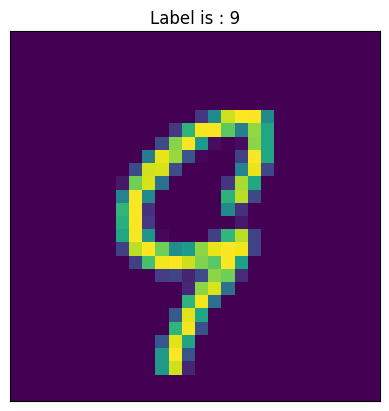

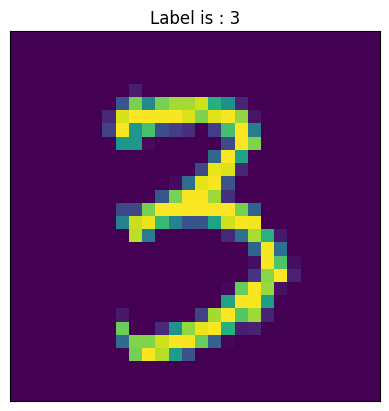

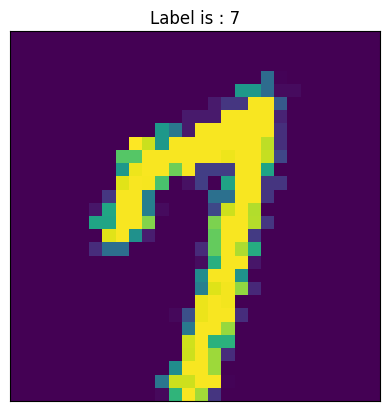

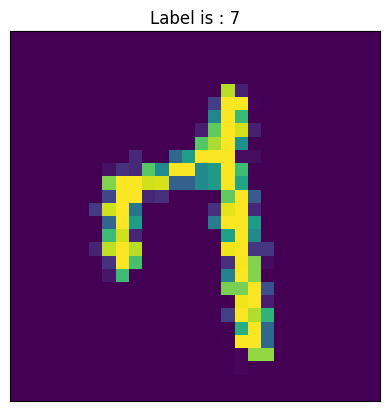

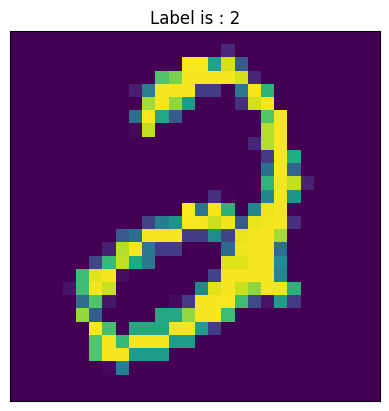

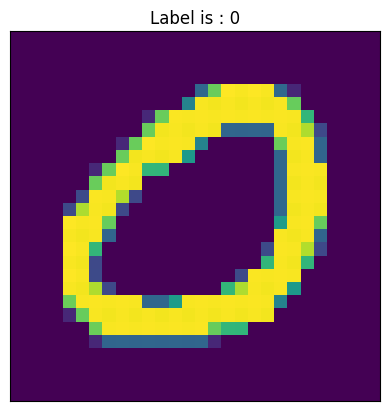

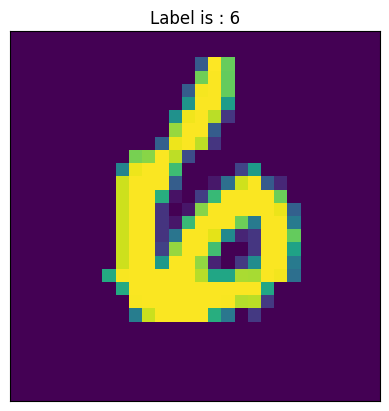

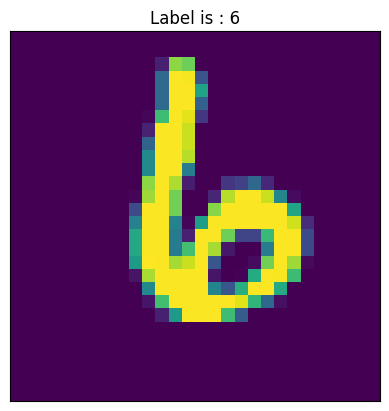

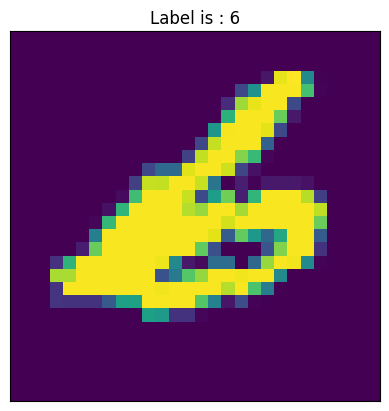

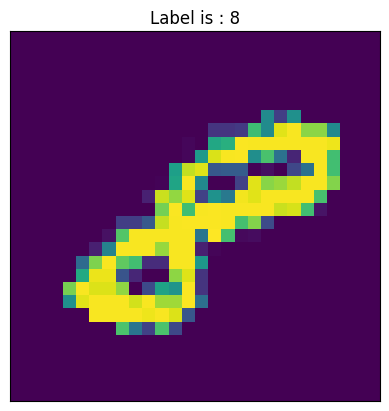

In [12]:
## Visualizing some of the results ##

torch.manual_seed(97)

vit.load_state_dict(torch.load(CKPT))

vit.eval()

rand_idx = torch.randint(low=0, high=len(test_dataset), size=(10,)).tolist()

for i in rand_idx:
    img = test_dataset[i][0]
    img = img.unsqueeze(0).to(DEVICE)
    pred = vit(img, device=DEVICE)
    probs = torch.nn.functional.softmax(pred, dim=1)
    label = torch.argmax(probs, dim=1).item()

    plt.title(f"Label is : {label}")
    plt.imshow(img.squeeze(0).detach().cpu().permute(1, 2, 0))
    plt.tick_params(
        left=False, right=False, labelleft=False, labelbottom=False, bottom=False
    )
    plt.show()


Looks exceptionally good. And that's it... Vision Transformers all coded up from Scratch!!
